In [102]:
# algorithm taken from http://www2.isye.gatech.edu/~jjb/research/mow/mow.pdf
def sierpinski_index(x, y, max_input = 100):
    loop_index = max_input;
    result = 0
    if x > y:
        result += 1
        x = max_input - x
        y = max_input - y
    while loop_index > 0:
        result *= 2
        if x + y > max_input:
            result += 1
            oldx = x
            x = max_input - y
            y = oldx
        x *= 2
        y *= 2
        result *= 2
        if y > max_input:
            result += 1
            oldx = x;
            x = y - max_input
            y = max_input - oldx
        loop_index /= 2
    return result

In [103]:
from math import *
from random import *
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 9, 9

def get_all_points_on_square(max_input):
    coords = []
    for x in xrange(max_input + 1):
        for y in xrange(max_input + 1):
            coords.append([x, y])
    return coords
    
def get_randoms(all_coords_, n):
    coords = []
    all_coords = all_coords_[:] # deep-copy
    for i in xrange(n):
        if i == 0:
            r = 0
        else:
            r = randrange(0, len(all_coords))
        coords.append(all_coords[r])
        del all_coords[r]
    return coords

def get_sierpinski_route(coords, max_input):
    indices = []
    for i in xrange(len(coords)):
        indices.append(sierpinski_index(coords[i][0], coords[i][1], max_input))
    lookup = {}
    for i in xrange(len(indices)):
        lookup[indices[i]] = i
    indices = sorted(indices)
    route = []
    for i in xrange(len(indices)):
        route.append(lookup[indices[i]])
    return route

def xy_from_route(coords, route):
    sorted_xs = []
    sorted_ys = []
    for i in xrange(len(route)):
        coord = coords[route[i]]
        sorted_xs.append(coord[0])
        sorted_ys.append(coord[1])
    return sorted_xs, sorted_ys

def print_route(sorted_xs, sorted_ys):
    plt.plot(sorted_xs, sorted_ys, marker='o')

def fill_square(max_input = 100):
    coords = get_all_points_on_square(max_input)
    route = get_sierpinski_route(coords, max_input)
    print_route(*xy_from_route(coords, route))

In [104]:
sierpisnki_index(2, 2)

NameError: name 'sierpisnki_index' is not defined

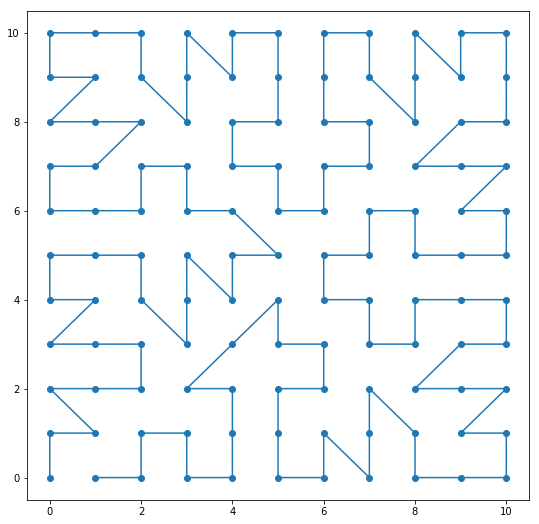

In [21]:
max_input = 10
fill_square(max_input)

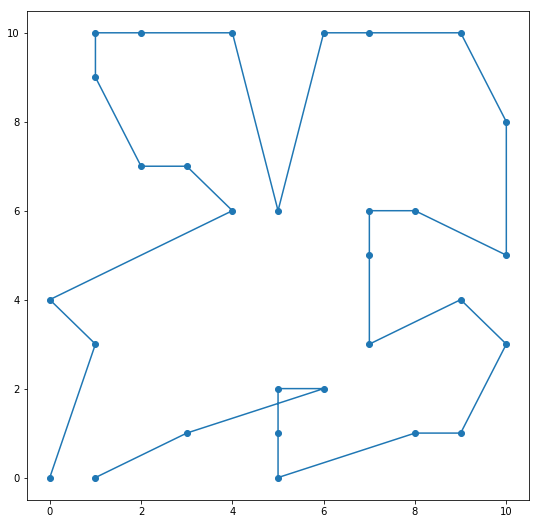

In [27]:
max_input = 10
n = 30
coords = get_randoms(get_all_points_on_square(max_input), n)
print_route(*xy_from_route(coords, get_sierpinski_route(coords, max_input)))

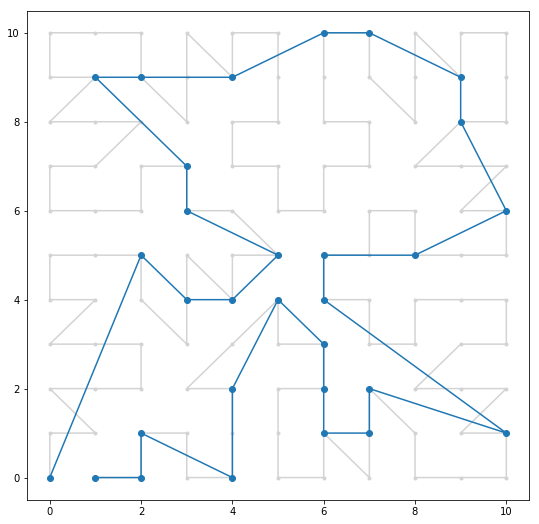

In [89]:
max_input = 10
n = 30
all_coords = get_all_points_on_square(max_input)
coords = get_randoms(all_coords, n)
backdrop = get_sierpinski_route(all_coords, max_input)
route = get_sierpinski_route(coords, max_input)
bdrop_xs, bdrop_ys = xy_from_route(all_coords, backdrop)
route_xs, route_ys = xy_from_route(coords, route)
plt.plot(bdrop_xs, bdrop_ys, color='lightgray', marker='.')
plt.plot(route_xs, route_ys, marker='o')

In [4]:
import os
import sys
os.chdir('/home/mtrencseni/or-tools')
sys.path.append('/home/mtrencseni/or-tools/lib')

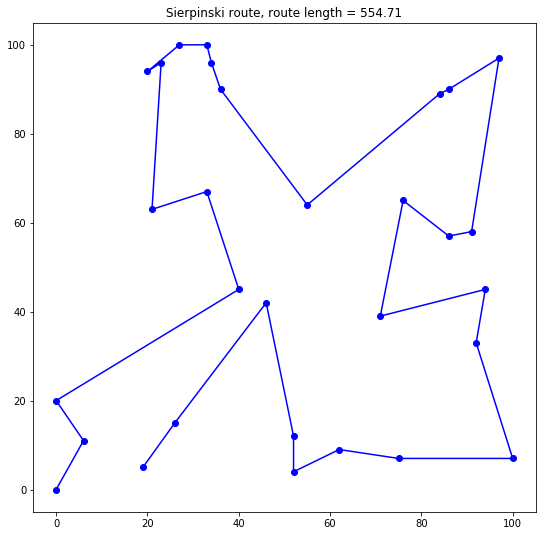

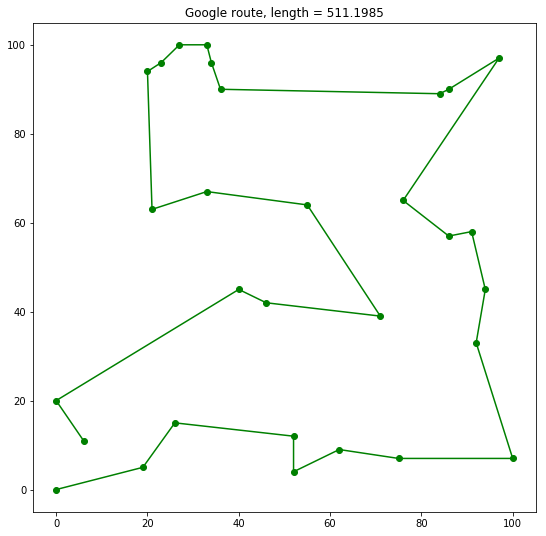

In [112]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

precision_scale = 10000
def l2(p1, p2):
    return floor(precision_scale*sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

# def l2_floor(p1, p2):
#     return floor(sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def get_distances(coords, dist):
    distances = {}
    for i in xrange(len(coords)):
        distances[i] = {}
        for j in xrange(len(coords)):
            distances[i][j] = dist(coords[i], coords[j])
    return distances

class DistanceCallback(object):
  def __init__(self, coords, dist):
    self.distances = get_distances(coords, dist)
  def dist(self, i, j):
    return self.distances[i][j]

def get_google_route(coords):
    routing = pywrapcp.RoutingModel(len(coords), 1, 0)
    dcb = DistanceCallback(coords, l2)
    dist_callback = dcb.dist
    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    assignment = routing.SolveWithParameters(search_parameters)
    #print "Total distance: " + str(assignment.ObjectiveValue()/precision_scale) + " miles\n"
    route = []
    if assignment:
        index = routing.Start(0)
        while True:
            route.append(routing.IndexToNode(index))
            index = assignment.Value(routing.NextVar(index))
            if routing.IsEnd(index): break
    return route

def total_dist(coords, route, dist, include_way_home=True):
    i = 0
    p1 = coords[route[i]]
    total = 0.0
    for i in xrange(1, len(route)):
        p2 = coords[route[i]]
        total += dist(p1, p2)
        p1 = p2
    if include_way_home:
        total += dist(coords[route[-1]], coords[route[0]])
    return total/precision_scale

max_input = 100
n = 30
all_coords = get_all_points_on_square(max_input)
coords = get_randoms(all_coords, n)
#backdrop = get_sierpinski_route(all_coords, max_input)
sierpinski_route = get_sierpinski_route(coords, max_input)
sierpinski_length = total_dist(coords, sierpinski_route, l2)
google_route = get_google_route(coords)
google_length = total_dist(coords, google_route, l2)
#xy_backdrop = xy_from_route(all_coords, backdrop)
xy_sierpinski_route = xy_from_route(coords, sierpinski_route)
xy_google_route = xy_from_route(coords, google_route)
plt.title('Sierpinski route, route length = %s' % sierpinski_length)
#plt.plot(*xy_backdrop, color='lightgray', marker='.')
plt.plot(*xy_sierpinski_route, color='blue', marker='o')
plt.show()
plt.title('Google route, length = %s' % google_length)
#plt.plot(*xy_backdrop, color='lightgray', marker='.')


plt.plot(*xy_google_route, color='green', marker='o')

In [131]:
from __future__ import print_function
import numpy as np

max_input = 1000
n = 100
num_routes = 100

all_coords = get_all_points_on_square(max_input)

lifts = []
for i in xrange(num_routes):
    print('%s     ' % (i), end='\r')
    coords = get_randoms(all_coords, n)
    sierpinski_route = get_sierpinski_route(coords, max_input)
    sierpinski_length = total_dist(coords, sierpinski_route, l2)
    google_route = get_google_route(coords)
    google_length = total_dist(coords, google_route, l2)
    lift = sierpinski_length / google_length - 1
    lifts.append(lift)

print(np.mean(lifts), np.std(lifts))

0.183298984304 0.0427825948055


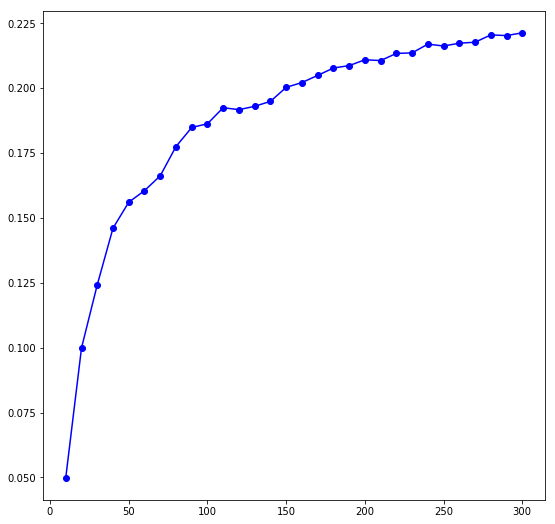

In [ ]:
from __future__ import print_function
import numpy as np

max_input = 3000

def get_google_lift(route_length):
    all_coords = get_all_points_on_square(max_input)
    lifts = []
    num_samples = 400
    for i in xrange(num_samples):
        print('%s %s     ' % (route_length, i), end='\r')
        coords = get_randoms(all_coords, route_length)
        sierpinski_route = get_sierpinski_route(coords, max_input)
        sierpinski_length = total_dist(coords, sierpinski_route, l2)
        google_route = get_google_route(coords)
        google_length = total_dist(coords, google_route, l2)
        lift = sierpinski_length / google_length - 1
        lifts.append(lift)
    return np.mean(lifts)

route_lengths = []
lifts = []
for route_length in xrange(10, 301, 10):
    lift = get_google_lift(route_length)
    route_lengths.append(route_length)
    lifts.append(lift)
    
plt.title('Google advantage over sierpisnki' % sierpinski_length)
plt.plot(route_lengths, lifts, color='blue', marker='o')

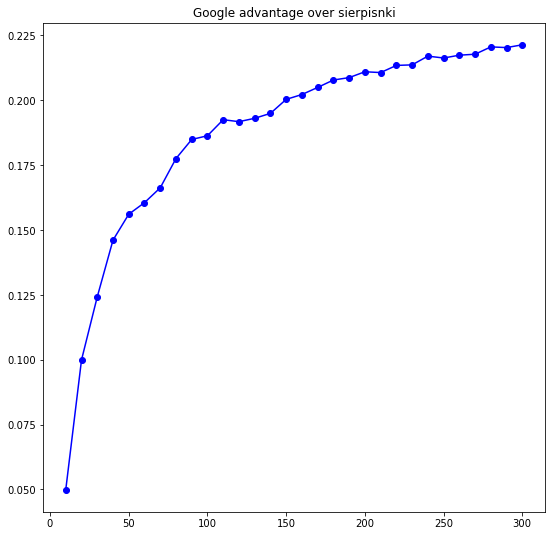

In [144]:
plt.title('Google advantage over sierpisnki')
plt.plot(route_lengths, lifts, color='blue', marker='o')